# Sistema de Recomendación con MovieLens (Dataset Small) - Canaza Tito, Eddy Wilmer

## Datos de la Práctica
Autor: Canaza tito, Eddy Wilmer

Dataset:
These datasets will change over time, and are not appropriate for reporting research results. We will keep the download links stable for automated downloads. We will not archive or make available previously released versions.

Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

## Carga de datos

In [23]:
from google.colab import drive
import pandas as pd
import numpy as np
import time

# Función para medir el tiempo de ejecución
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

# Carga de datos
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Maestría/Recuperación de información/SR/ds/'

ratings_df = pd.read_csv(f'{file_path}/ratings.csv')
movies_df = pd.read_csv(f'{file_path}/movies.csv')

merged_df = pd.merge(ratings_df, movies_df, on='movieId', how='left')

# Construye una matriz para realizar las operaciones con las calificaciones
pivot_table = merged_df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

merged_df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


## Funciones para los cálculos de distancia o similitudes

In [24]:
# Calcula la distancia Euclidiana
def euclidean_distance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)

# Calcula la distancia Manhattan
def manhattan_distance(vec1, vec2):
    return np.sum(np.abs(vec1 - vec2))

# Calcula la similitud Pearson
def pearson_similarity(vec1, vec2):
    mean1, mean2 = np.mean(vec1), np.mean(vec2)
    num = np.sum((vec1 - mean1) * (vec2 - mean2))
    den = np.sqrt(np.sum((vec1 - mean1) ** 2) * np.sum((vec2 - mean2) ** 2))
    if den == 0:
        return 0
    return num / den

# Calcula la similitud Coseno
def cosine_similarity(vec1, vec2):
    num = np.dot(vec1, vec2)
    den = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    if den == 0:
        return 0
    return num / den

## KNN para identificar las peliculas recomendadas

El modelo de recomedación permite establecer las películas que le pueden gustar a un usuario específico a partir de un n-vecinos utilizando una distancia o similitud ('euclidean', 'manhattan', 'pearson' o 'cosine'). Para que las películas sean consideradas en la recomendación deben de superar el rating mínimo que se establece.\

,Sample Size,Data Loading Time,Distance Calculation Time,Recommendation Time,Total Time
0,250,0.030183,0.000292,0.029976,0.060451
1,500,0.048239,0.001068,0.067312,0.116618
2,1000,0.103615,0.003598,0.014946,0.122159
3,2500,0.192092,0.021438,0.018399,0.231929
4,5000,0.298462,0.042166,0.020983,0.361610
5,10000,0.432858,0.120578,0.030279,0.583715
6,12500,0.544309,0.277109,0.045779,0.867198
7,25000,0.908879,0.880113,0.048849,1.837841
8,50000,1.077762,1.110837,0.027556,2.216155
9,100000,1.454702,2.919572,0.036551,4.410824


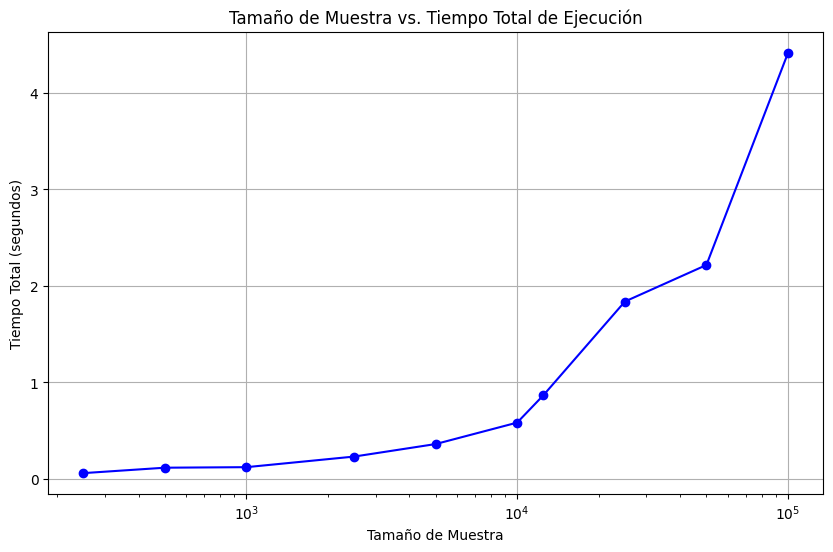

In [25]:
# Lista de tamaños de muestra
sample_sizes = [250, 500, 1000, 2500, 5000, 10000, 12500, 25000, 50000, 100000]

# Tabla de tiempos de ejecución
execution_times = []

for size in sample_sizes:
    # Crear un archivo temporal con los datos filtrados
    temp_file_path = '/content/temp_ratings.csv'
    ratings_df.head(size).to_csv(temp_file_path, index=False)

    # Medir el tiempo de carga de datos desde el archivo temporal
    start_time = time.time()
    temp_ratings_df = pd.read_csv(temp_file_path)
    merged_df = pd.merge(temp_ratings_df, movies_df, on='movieId', how='left')
    pivot_table = merged_df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
    end_time = time.time()
    data_loading_time = end_time - start_time

    def knn_recommendation(user_id, n_neighbors, distance_type='euclidean', min_rating=0, printable=True):
        if user_id not in pivot_table.index:
            raise ValueError("El user_id no está en la base de datos.")

        user_ratings = pivot_table.loc[user_id].values
        distances = []

        start_time_distances = time.time()
        for other_user_id in pivot_table.index:
            if other_user_id == user_id:
                continue
            other_user_ratings = pivot_table.loc[other_user_id].values

            if distance_type == 'euclidean':
                distance = euclidean_distance(user_ratings, other_user_ratings)
            elif distance_type == 'manhattan':
                distance = manhattan_distance(user_ratings, other_user_ratings)
            elif distance_type == 'pearson':
                distance = 1 - pearson_similarity(user_ratings, other_user_ratings)
            elif distance_type == 'cosine':
                distance = 1 - cosine_similarity(user_ratings, other_user_ratings)
            else:
                raise ValueError("Tipo de distancia no válido. Use 'euclidean', 'manhattan', 'pearson' o 'cosine'.")

            distances.append((other_user_id, distance))
        end_time_distances = time.time()
        distance_calculation_time = end_time_distances - start_time_distances

        neighbors = sorted(distances, key=lambda x: x[1])[:n_neighbors]

        start_time_recommendation = time.time()
        # Obtiene las películas y ratings de los vecinos que superan el min_rating
        recommendations = []
        for neighbor_id, distance in neighbors:
            neighbor_ratings = pivot_table.loc[neighbor_id]
            recommended_movies = neighbor_ratings[neighbor_ratings > min_rating].index.tolist()

            if not recommended_movies:
                print(f"id_neighbor: {neighbor_id}: Ninguna película supera el min_rating de {min_rating}.")
            else:
                for movie_id in recommended_movies:
                    movie_title = movies_df.loc[movies_df['movieId'] == movie_id, 'title'].values[0]
                    rating = neighbor_ratings[movie_id]
                    recommendations.append((neighbor_id, distance, movie_id, movie_title, rating))

        # Convierte las recomendaciones en un DataFrame
        recommendations_df = pd.DataFrame(recommendations, columns=['neighbor_id', 'distance', 'movie_id', 'movie_title', 'rating'])
        recommendations_df = recommendations_df.drop_duplicates(subset='movie_id', keep='first')
        recommendations_df['distance'] = recommendations_df['distance'].round(4)

        # Ordena las películas recomendadas por su rating
        recommendations_df = recommendations_df.groupby(['neighbor_id', 'distance']).apply(lambda x: x.sort_values(by='rating', ascending=False))
        recommendations_df.reset_index(drop=True, inplace=True)

        # Imprime los resultados
        if printable:
            for (id_neighbor, distance), group_df in recommendations_df.groupby(['neighbor_id', 'distance']):
                print(f"id_neighbor: {id_neighbor}, distance: {distance}:")
                for index, row in group_df.iterrows():
                    print(f"\t{row['movie_id']}, {row['movie_title']}, {row['rating']}")

        end_time_recommendation = time.time()
        recommendation_time = end_time_recommendation - start_time_recommendation

        total_time = data_loading_time + distance_calculation_time + recommendation_time

        if not printable:
            return recommendations_df, data_loading_time, distance_calculation_time, recommendation_time, total_time

    # Parámetros del Test
    user_id = 2 # Usuario
    distance_type = 'pearson' # Métrica o similitud
    n_neighbors = 3 # Número de vecinos
    min_rating = 4.5 # Score mínimo para ser considerado en la recomendacion

    # # Ejecutar la recomendación y medir los tiempos
    recommendations, load_time, dist_time, rec_time, total_time = knn_recommendation(user_id, n_neighbors, distance_type, min_rating, printable=False)
    execution_times.append([size, load_time, dist_time, rec_time, total_time])

# Crear un DataFrame con los tiempos de ejecución
times_df = pd.DataFrame(execution_times, columns=['Sample Size', 'Data Loading Time', 'Distance Calculation Time', 'Recommendation Time', 'Total Time'])

# Mostrar la tabla de tiempos de ejecución
from IPython.display import display
display(times_df)


import matplotlib.pyplot as plt

# Generar la gráfica de Tamaño de Muestra vs. Tiempo Total de Ejecución
plt.figure(figsize=(10, 6))
plt.plot(times_df['Sample Size'], times_df['Total Time'], marker='o', linestyle='-', color='b')

# Añadir título y etiquetas
plt.title('Tamaño de Muestra vs. Tiempo Total de Ejecución')
plt.xlabel('Tamaño de Muestra')
plt.ylabel('Tiempo Total (segundos)')

# Escala logarítmica para el eje x
plt.xscale('log')

# Mostrar la gráfica
plt.grid(True)
plt.show()


In [26]:
# Parámetros del Test
user_id = 2 # Usuario
distance_type = 'pearson' # Métrica o similitud
n_neighbors = 3 # Número de vecinos
min_rating = 4.5 # Score mínimo para ser considerado en la recomendacion

knn_recommendation(user_id, n_neighbors, distance_type, min_rating, printable=True)

id_neighbor: 366, distance: 0.7021:
	1089, Reservoir Dogs (1992), 5.0
	109487, Interstellar (2014), 5.0
id_neighbor: 378, distance: 0.7267:
	48780, Prestige, The (2006), 5.0
	79132, Inception (2010), 5.0
id_neighbor: 417, distance: 0.7227:
	47, Seven (a.k.a. Se7en) (1995), 5.0
	4975, Vanilla Sky (2001), 5.0
	4995, Beautiful Mind, A (2001), 5.0
	5952, Lord of the Rings: The Two Towers, The (2002), 5.0
	6016, City of God (Cidade de Deus) (2002), 5.0
	6874, Kill Bill: Vol. 1 (2003), 5.0
	7153, Lord of the Rings: The Return of the King, The (2003), 5.0
	7254, The Butterfly Effect (2004), 5.0
	27773, Old Boy (2003), 5.0
	47099, Pursuit of Happyness, The (2006), 5.0
	55247, Into the Wild (2007), 5.0
	68157, Inglourious Basterds (2009), 5.0
	74458, Shutter Island (2010), 5.0
	79357, Mr. Nobody (2009), 5.0
	84152, Limitless (2011), 5.0
	92259, Intouchables (2011), 5.0
	106782, Wolf of Wall Street, The (2013), 5.0
	4993, Lord of the Rings: The Fellowship of the Ring, The (2001), 5.0
	4896, Harr